# Market regime filter example

- Test out GaussianHMM
- See https://www.quantstart.com/articles/market-regime-detection-using-hidden-markov-models-in-qstrader/

## Download data

- Train on Binance daily data
- Only consider major pairs (may cause survivorship bias)

In [19]:
import datetime
from tradingstrategy.timebucket import TimeBucket
from tradingstrategy.chain import ChainId
from tradeexecutor.utils.binance import create_binance_universe

strategy_universe = create_binance_universe(
    ["ETHUSDT", "MATICUSDT", "BTCUSDT", "SOLUSDT", "BNBUSDT", "DOGEUSDT", "XRPUSDT"],   # Binance internal tickers later mapped to Trading strategy DEXPair metadata class
    candle_time_bucket=TimeBucket.d1,
    start_at=datetime.datetime(2018, 1, 1),  # Backtest for 5 years data
    end_at=datetime.datetime(2024, 3, 10),
    include_lending=False
)


  0%|          | 0/7 [00:00<?, ?it/s]

## Create returns series

- For each pair, create returns series.

In [20]:
import pandas as pd

returns = pd.DataFrame()
closes = pd.DataFrame()
universe = strategy_universe.data_universe
for pair in universe.pairs.iterate_pairs():
    close = universe.candles.get_candles_by_pair(pair)["close"]
    close = close.dropna()
    returns[pair.get_ticker()] = close.pct_change()
    closes[pair.get_ticker()] = close

returns = returns.ffill().dropna()
display(returns)


,ETH-USDT,MATIC-USDT,BTC-USDT,SOL-USDT,BNB-USDT,DOGE-USDT,XRP-USDT
timestamp,,,,,,,
2020-08-12,0.021583,0.097699,0.015120,0.138639,0.009474,0.020645,-0.002720
2020-08-13,0.096493,0.073972,0.018650,-0.006869,0.012786,0.007831,0.042043
2020-08-14,0.031964,0.038674,-0.001652,-0.085818,0.061470,0.024486,0.019545
2020-08-15,-0.013216,0.065603,0.007811,-0.069474,-0.000718,-0.011279,-0.003701
2020-08-16,0.003007,0.002995,0.004944,0.067917,0.019096,-0.000736,0.019107
...,...,...,...,...,...,...,...
2024-03-06,0.074554,0.082164,0.036878,0.043732,0.089571,0.031364,0.035352
2024-03-07,0.013138,0.037829,0.011338,0.099625,0.105263,-0.001267,0.024342
2024-03-08,0.003774,-0.030246,0.019470,0.006745,0.023599,0.043961,-0.011164


# Train model

In [21]:
 from hmmlearn.hmm import GaussianHMM

 hmm_model = GaussianHMM(
    n_components=2,
    covariance_type="full",
    n_iter=1000
).fit(returns)
print("Model Score:", hmm_model.score(returns))

Model Score: 15751.022712979579


# Plot model

IndexError: Boolean index has wrong length: 1307 instead of 2261

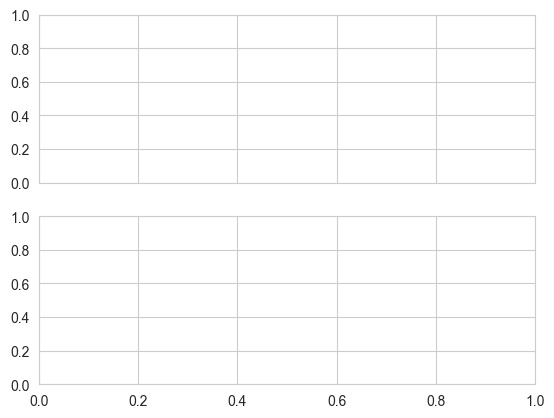

In [22]:
from matplotlib import cm, pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator
import numpy as np
import pandas as pd
import seaborn as sns

def plot_in_sample_hidden_states(hmm_model, df):
    """
    Plot the adjusted closing prices masked by
    the in-sample hidden states as a mechanism
    to understand the market regimes.
    """
    # Predict the hidden states array
    hidden_states = hmm_model.predict(returns)
    # Create the correctly formatted plot
    fig, axs = plt.subplots(
        hmm_model.n_components,
        sharex=True, sharey=True
    )
    colours = cm.rainbow(
        np.linspace(0, 1, hmm_model.n_components)
    )
    for i, (ax, colour) in enumerate(zip(axs, colours)):
        mask = hidden_states == i
        ax.plot_date(
            df.index[mask],
            df[mask],
            ".", linestyle='none',
            c=colour
        )
        ax.set_title("Hidden State #%s" % i)
        ax.xaxis.set_major_locator(YearLocator())
        ax.xaxis.set_minor_locator(MonthLocator())
        ax.grid(True)
    plt.show()


plot_in_sample_hidden_states(hmm_model, closes)